In [190]:
from collections import Counter

import pandas as pd

from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

%matplotlib inline

In [161]:
df = pd.read_csv('comments.csv', encoding='utf-8', sep=';', error_bad_lines=False)

Skipping line 20650: expected 6 fields, saw 7



In [162]:
df.columns = ['time', 'profile', 'username', 'plus', 'minus', 'text']

In [163]:
df.fillna('', inplace=True)

In [164]:
df = df[df['minus'] <= 0]

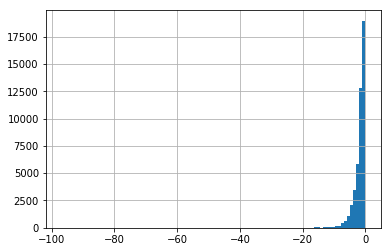

In [165]:
df.minus.hist(bins=100)

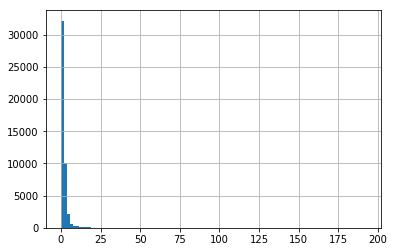

In [166]:
df.plus.hist(bins=100)

In [167]:
df.head()

,time,profile,username,plus,minus,text
0,1499599723000,https://profile.hypercomments.com/7817694,Игорь,0,-16,
1,1499608692000,https://profile.hypercomments.com/2391496,Ал Екс,3,-21,
2,1499610553000,https://profile.hypercomments.com/7844634,Fedaris Gumerov,11,-4,Ты на самом деле ЁБНУТЫЙ..?
3,1499610588000,https://profile.hypercomments.com/7844634,Fedaris Gumerov,3,-2,Ты на самом деле ПРИЁБНУТЫЙ...?
4,1499620277000,https://profile.hypercomments.com/2391496,Ал Екс,1,-20,


In [168]:
df.plus.sum()

69221

In [169]:
df.minus.sum()

-67530

In [170]:
df.plus.describe()

count    46061.000000
mean         1.502811
std          3.880927
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max        192.000000
Name: plus, dtype: float64

In [171]:
df.minus.describe()

count    46061.000000
mean        -1.466099
std          2.625720
min        -97.000000
25%         -2.000000
50%         -1.000000
75%          0.000000
max          0.000000
Name: minus, dtype: float64

In [172]:
# df = df[(df['minus'] < -2) | (df['plus'] > 2)]

In [173]:
def summary(row):
    return int(row['minus']) + int(row['plus'])

df['total'] = df.apply(summary, axis=1)

In [174]:
df = df[(df['total'] > 0) | (df['total'] < 0)]

In [175]:
df = df[df.text != '']

In [176]:
df['is_bot'] = df.total.apply(lambda x: 1 if x < 0 else 0)

In [177]:
counter = Counter()

for i, row in df.iterrows():
    profile = row['profile']
    text = row['text']
    counter.update([(profile, text)])

In [178]:
bot_profiles = set()
for tuple_profile_text, count in counter.most_common():
    if count == 1:
        break
    profile, text = tuple_profile_text
    bot_profiles.add(profile)

In [179]:
len(bot_profiles)

50

In [180]:
df.shape

(25389, 8)

In [181]:
df.ix[df.profile.isin(bot_profiles), 'is_bot'] = 1

/Users/toly/projects/hypercomments_parser/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [182]:
df.drop_duplicates(subset=['text'], inplace=True)

In [183]:
df.is_bot.value_counts()

1    18687
0     6063
Name: is_bot, dtype: int64

In [148]:
model = Pipeline([
    ('vectors', FeatureUnion([
        ('chars', TfidfVectorizer(ngram_range=(1, 5), analyzer='char', min_df=10)),
        ('words', TfidfVectorizer(ngram_range=(1, 2), min_df=10)),
    ])),
    ('logistic', LogisticRegression(class_weight='balanced'))
])

In [149]:
for score in cross_val_score(model, df.text, df.is_bot, cv=5):
    print score

0.680064633407
0.719046657241
0.690909090909
0.747019599919
0.7171145686


In [150]:
for score in cross_val_score(model, df.text, df.is_bot, cv=5, scoring='f1'):
    print score

0.778275475924
0.804497540408
0.776315789474
0.830627705628
0.803315538072


In [152]:
model = Pipeline([
    ('vectors', FeatureUnion([
        ('chars', TfidfVectorizer(ngram_range=(1, 5), analyzer='char', min_df=10)),
        ('words', TfidfVectorizer(ngram_range=(1, 2), min_df=10)),
    ])),
    ('logistic', SGDClassifier(class_weight='balanced'))
])

/Users/toly/projects/hypercomments_parser/env/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [153]:
for score in cross_val_score(model, df.text, df.is_bot, cv=5, scoring='f1'):
    print score

0.741719887123
0.806880156621
0.761127596439
0.820540985857
0.806732117812


# best solution candidate

In [184]:
model = Pipeline([
    ('vectors', FeatureUnion([
        ('chars', TfidfVectorizer(ngram_range=(1, 5), analyzer='char', min_df=10)),
        ('words', TfidfVectorizer(ngram_range=(1, 2), min_df=10)),
    ])),
    ('logistic', GradientBoostingClassifier())
])

In [156]:
for score in cross_val_score(model, df.text, df.is_bot, cv=5, scoring='f1'):
    print score

0.861144077854
0.869916765755
0.858947879966
0.871488344292
0.869606674613


In [185]:
for score in cross_val_score(model, df.text, df.is_bot, cv=5):
    print score

0.763482124823
0.778630579681
0.766060606061
0.78116791271
0.77955142453


In [186]:
model.fit(df.text, df.is_bot)

Pipeline(memory=None,
     steps=[('vectors', FeatureUnion(n_jobs=1,
       transformer_list=[('chars', TfidfVectorizer(analyzer='char', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [187]:
model.predict_proba([
    'Убить Дурицкого.',
    'врешь как либеральная сволочь',
    'Чья бы корова мычала, в твоей хохляндии пенсии по 40 долларов и зарплаты по 100 долларов. А стоимость коммуналки как европах.',
    'Россия встала скален Рoссиян уже который год кормят мукой из фуражного зерна, предназначенного исключительно для скота',
    'Навальный красавчик! Во прикол будет, кремлепуты залезут счёта посмотреть, а там хер начивал, охренеют по полной)))))',
])

array([[ 0.14603486,  0.85396514],
       [ 0.18119103,  0.81880897],
       [ 0.10399919,  0.89600081],
       [ 0.26962145,  0.73037855],
       [ 0.39918175,  0.60081825]])

In [189]:
joblib.dump(model, 'model_hypercomments.pkl')

['model_hypercomments.pkl']

In [193]:
fpr, tpr, thresholds = roc_curve(df.is_bot, model.predict_proba(df.text)[:, 1])

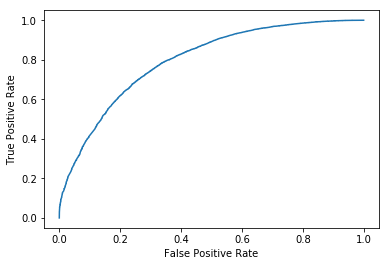

In [197]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [198]:
model = Pipeline([
    ('vectors', FeatureUnion([
        ('chars', TfidfVectorizer(ngram_range=(1, 5), analyzer='char', min_df=10)),
        ('words', TfidfVectorizer(ngram_range=(1, 2), min_df=10)),
    ])),
    ('logistic', LogisticRegression(class_weight='balanced'))
])

In [199]:
model.fit(df.text, df.is_bot)

Pipeline(memory=None,
     steps=[('vectors', FeatureUnion(n_jobs=1,
       transformer_list=[('chars', TfidfVectorizer(analyzer='char', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [200]:
joblib.dump(model, 'model_hypercomments2.pkl')

['model_hypercomments2.pkl']

In [201]:
fpr, tpr, thresholds = roc_curve(df.is_bot, model.predict_proba(df.text)[:, 1])

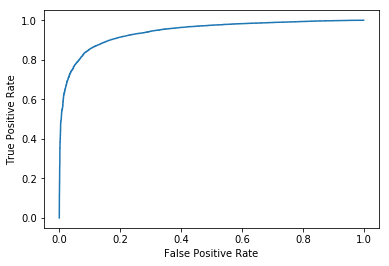

In [202]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [206]:
u = model.steps[0][1]

In [209]:
vectorizer = u.transformer_list[1][1]

In [211]:
len(vectorizer.vocabulary_)

5007

In [212]:
model.predict_proba([
    'Убить Дурицкого.',
    'врешь как либеральная сволочь',
    'Чья бы корова мычала, в твоей хохляндии пенсии по 40 долларов и зарплаты по 100 долларов. А стоимость коммуналки как европах.',
    'Россия встала скален Рoссиян уже который год кормят мукой из фуражного зерна, предназначенного исключительно для скота',
    'Навальный красавчик! Во прикол будет, кремлепуты залезут счёта посмотреть, а там хер начивал, охренеют по полной)))))',
])

array([[ 0.24221649,  0.75778351],
       [ 0.14105794,  0.85894206],
       [ 0.14035898,  0.85964102],
       [ 0.35912014,  0.64087986],
       [ 0.4587957 ,  0.5412043 ]])